# Pneumonia Classification in Chest X-rays using Transer Learning <br> (ResNet-18) + Grad-Cam

Grad-CAM is a class-discriminative localization technique that generates visual explanations for decisions made by Convolutional Neural Networks (CNNs), highlighting the image regions that most influence a specific prediction.

As stated by Ramprasaath R. et al.:
> "Grad-CAM uses the gradient information flowing into the last convolutional layer of the CNN to understand the importance of each neuron for a decision of interest."

Implementation and Mechanism In AI-assisted medical diagnosis, transparency is critical; "black box" models may offer high accuracy but lack clinical justification. We implement Grad-CAM to validate that the model identifies genuine pathological patterns (such as lung consolidations) rather than irrelevant artifacts (edges or markers), thereby ensuring the system's reliability.

To achieve this, the algorithm leverages the network's last convolutional layer, as it is the final point where detailed spatial information is preserved before being collapsed by fully connected layers. Grad-CAM calculates the gradient of the target class score with respect to the feature maps of said layer. These gradients are globally averaged (Global Average Pooling) to obtain "neuron importance weights." Finally, a weighted linear combination of the activation maps is performed, followed by a ReLU function, resulting in a heatmap that isolates only the features contributing positively to the pathology detection.

You can find more details in the original [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391)

### 1. Environment Setup and Library Imports
This section initializes the computational environment. Standard libraries for tensor manipulation (torch, numpy) and visualization (matplotlib) are imported. System paths are configured to access the local project structure, specifically the custom data loaders located in src/data. Additionally, the computation device is automatically selected, prioritizing Apple Silicon (MPS) or NVIDIA CUDA if available, to optimize performance.

In [ ]:
# Import libraries.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Data handling and preprocessing.
import numpy as np
from tqdm import tqdm
from PIL import Image

# Visualization and evaluation.
import matplotlib.pyplot as plt

# Configuration
sys.path.append(os.path.abspath(os.path.join("..")))
from src.data.dataloaders import get_loaders, get_transforms

# System and environment configuration.
import cv2
import os
import sys
plt.style.use("seaborn-v0_8-muted")
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["font.size"] = 11

# Device Configuration.

device = torch.device("mps" 
    if torch.backends.mps.is_available() 
    else "cuda" if torch.cuda.is_available() 
    else "cpu")
                      
print(f"Device: {device}")



Device: mps


### 2. Model Architecture Reconstruction and Weight Loading
To interpret the model's decisions, the exact architecture used during the training phase must be reconstructed. A **ResNet-18** model is instantiated, and its fully connected (classification) head is modified to match the binary classification task (Normal vs. Pneumonia).



The parameters are frozen to ensure the model remains in inference mode. The weights from the best-performing model (resnet_phase2.pth) are then loaded onto the selected device.

In [ ]:
# Reconstruct the model architecture.

def create_resnet_model(num_classes=2, dropout=0.5):
    """
    Reconstructs the exact architecture used during training.
    """
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    
    # Ensure layers are frozen/unfrozen consistent with the saved state
    # For inference/GradCAM, we strictly need the structure to match.
    for param in model.parameters():
        param.requires_grad = False
        
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.BatchNorm1d(256),
        nn.Linear(256, num_classes)
    )
    return model

# Load weights of the best model.
model = create_resnet_model().to(device)
model_path = "../models_saved/resnet_phase2.pth" 

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found: {model_path}")

try:
    state_dict = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    print(f"Model successfully loaded from: {model_path}")
except Exception as e:
    print(f"Error loading weights: {e}")

model.eval()

Model successfully loaded from: ../models_saved/resnet_phase2.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 3. Test Data Preparation
The test dataset is prepared using the get_loaders utility. This ensures that the validation images undergo the same preprocessing (resizing and normalization) as the training data, guaranteeing the validity of the evaluation.

In [ ]:
# Data Loaders.

_, test_loader = get_loaders(
    batch_size=16, 
    model_type="resnet", 
    data_dir="../data/chest_xray"
)

class_names = ["NORMAL", "PNEUMONIA"]
print(f"Test Loader initialized. Number of batches: {len(test_loader)}")

Apple Silicon detected. Setting num_workers to 0 for compatibility.
Test Loader initialized. Number of batches: 39


### 4. Grad-CAM Algorithm Implementation
The **GradCAM** class encapsulates the core logic for generating visual explanations.

**Key Features:**
1.  **Hooks:** It registers forward and backward hooks to capture the feature maps (activations) and the gradients flowing through the target layer during inference.
2.  **Gradient Calculation:** It computes the gradient of the target class score with respect to the feature maps.
3.  **Global Average Pooling:** It calculates the importance weights of the filters.
4.  **Heatmap Generation:** It combines the weighted activations and applies the ReLU function to filter out negative contributions.

In [ ]:
# Grad-CAM Implementation.

class GradCAM:
    """
    Implements Gradient-weighted Class Activation Mapping (Grad-CAM).
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Force gradient calculation for visualization.
        for param in self.model.parameters():
            param.requires_grad = True
        self.model.eval()

        # Register hooks.
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass.
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)
        
        # Backward pass.
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        if self.gradients is None:
            return np.zeros((x.shape[2], x.shape[3])), output, class_idx

        # Generate Heatmap.
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3])
        activations = self.activations.detach()
        
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[0, i]
            
        heatmap = torch.mean(activations, dim=1).squeeze().cpu()
        heatmap = torch.clamp(heatmap, min=0)
        
        if torch.max(heatmap) > 0:
            heatmap /= torch.max(heatmap)
            
        return heatmap.numpy(), output, class_idx

# Initialize GradCAM on the final convolutional layer.
gradcam = GradCAM(model, model.layer4)
print("Grad-CAM initialized on ResNet layer4.")

Grad-CAM initialized on ResNet layer4.


### 6. Visualization Helper Functions
These utilities process the raw tensors and heatmaps for human-readable display.

* **denormalize_image**: Reverses the ImageNet normalization applied during preprocessing to display the original X-ray image correctly.
* **process_single_image**: Handles loading and transformation for individual image files.
* **generate_visualization**: Overlays the activation heatmap onto the original image using the JET colormap, allowing for an intuitive interpretation of "hot" (high attention) and "cold" (low attention) zones.

In [ ]:
# Helper Functions.

def denormalize_image(img_tensor, device):
    """
    Denormalizes images using the specific statistics from dataloaders.py.
    """
    # ImageNet statistics matching to get_transforms function.
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    img_denorm = img_tensor * std + mean
    img_denorm = torch.clamp(img_denorm, 0, 1)
    img_np = img_denorm[0].cpu().permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    
    return img_np

def process_single_image(img_path, device):
    """
    Loads and preprocesses a single image using the custom get_transforms.
    """
    # Get the exact transformation pipeline used for testing
    preprocess = get_transforms(img_size=224, model_type="resnet", train=False)
    
    try:
        # Open image
        img_pil = Image.open(img_path).convert("RGB")
        img_tensor = preprocess(img_pil).unsqueeze(0).to(device)
        return img_tensor
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

def generate_visualization(gradcam, img_tensor, device, target_class=None):
    """
    Generates the heatmap and superimposed visualization.
    """
    img_np = denormalize_image(img_tensor, device)
    heatmap, output, pred_idx = gradcam(img_tensor, class_idx=target_class)
    
    # Resize heatmap to match image dimensions
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    # Superposition (heatmap * 0.4 + original)
    superimposed = heatmap_colored[..., ::-1] * 0.4 + img_np.astype(float) / 255.0 * 255
    superimposed = superimposed / np.max(superimposed)
    
    
    probs = F.softmax(output, dim=1)
    confidence = probs[0, pred_idx].item()
    
    return heatmap_resized, superimposed, pred_idx, confidence

### 7. Batch Visualization and Model Interpretation
This function iterates through a random batch from the test set to generate comparative visualizations. For each sample, it displays:
1.  **Original Image:** The raw chest X-ray.
2.  **Heatmap:** The isolated Grad-CAM activation map.
3.  **Superimposed:** The heatmap overlaid on the X-ray, providing clinical context.

This facilitates the verification of whether the model focuses on the lung fields (correct behavior) or external markers (potential bias).


--- Visualizing: NORMAL CASES ---


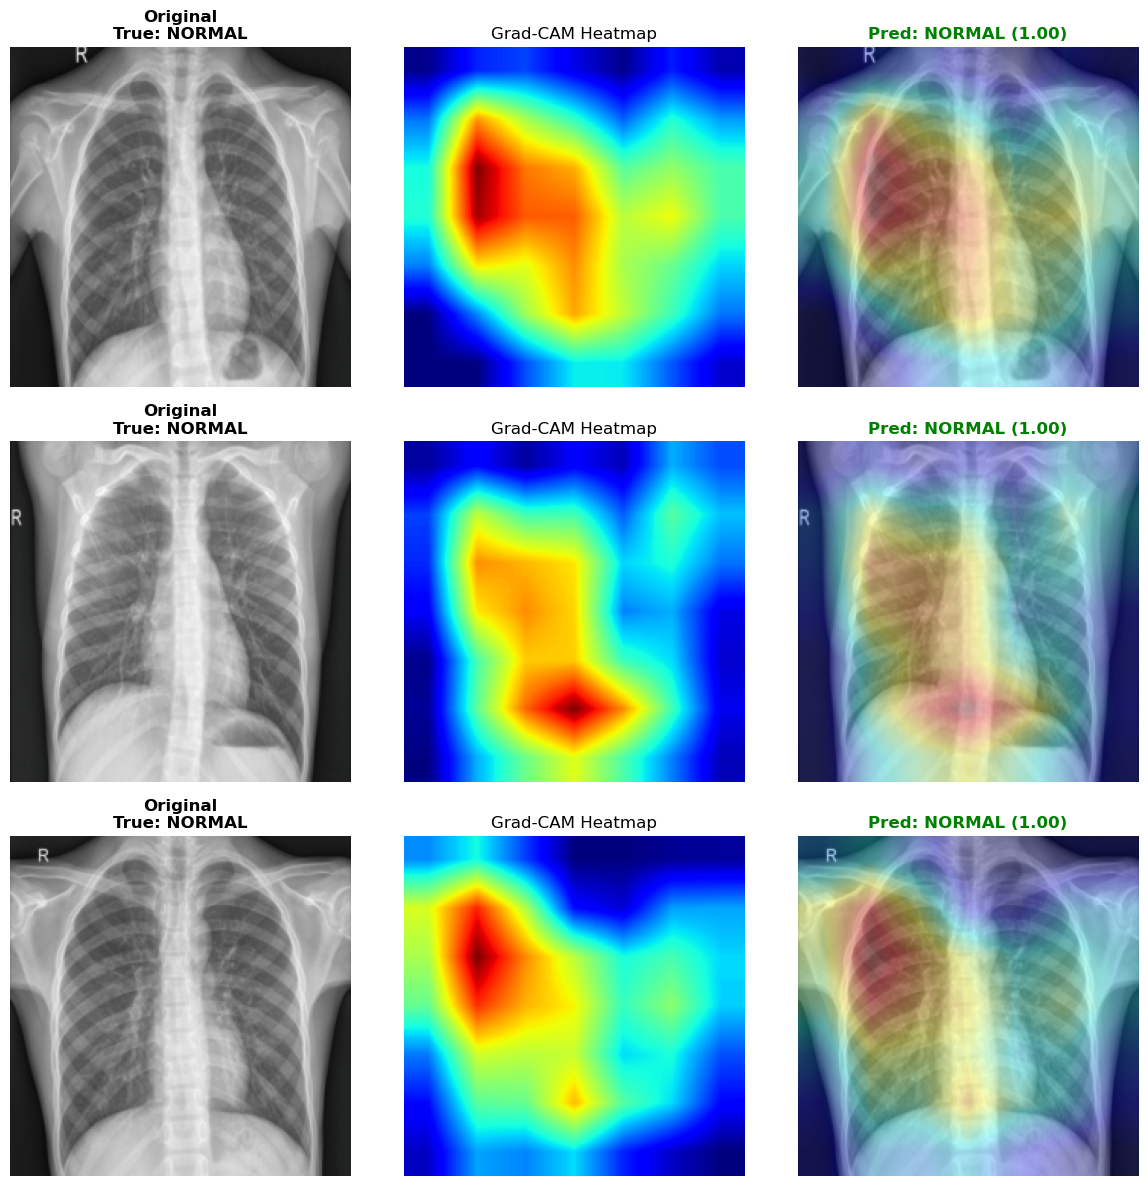


--- Visualizing: PNEUMONIA CASES ---


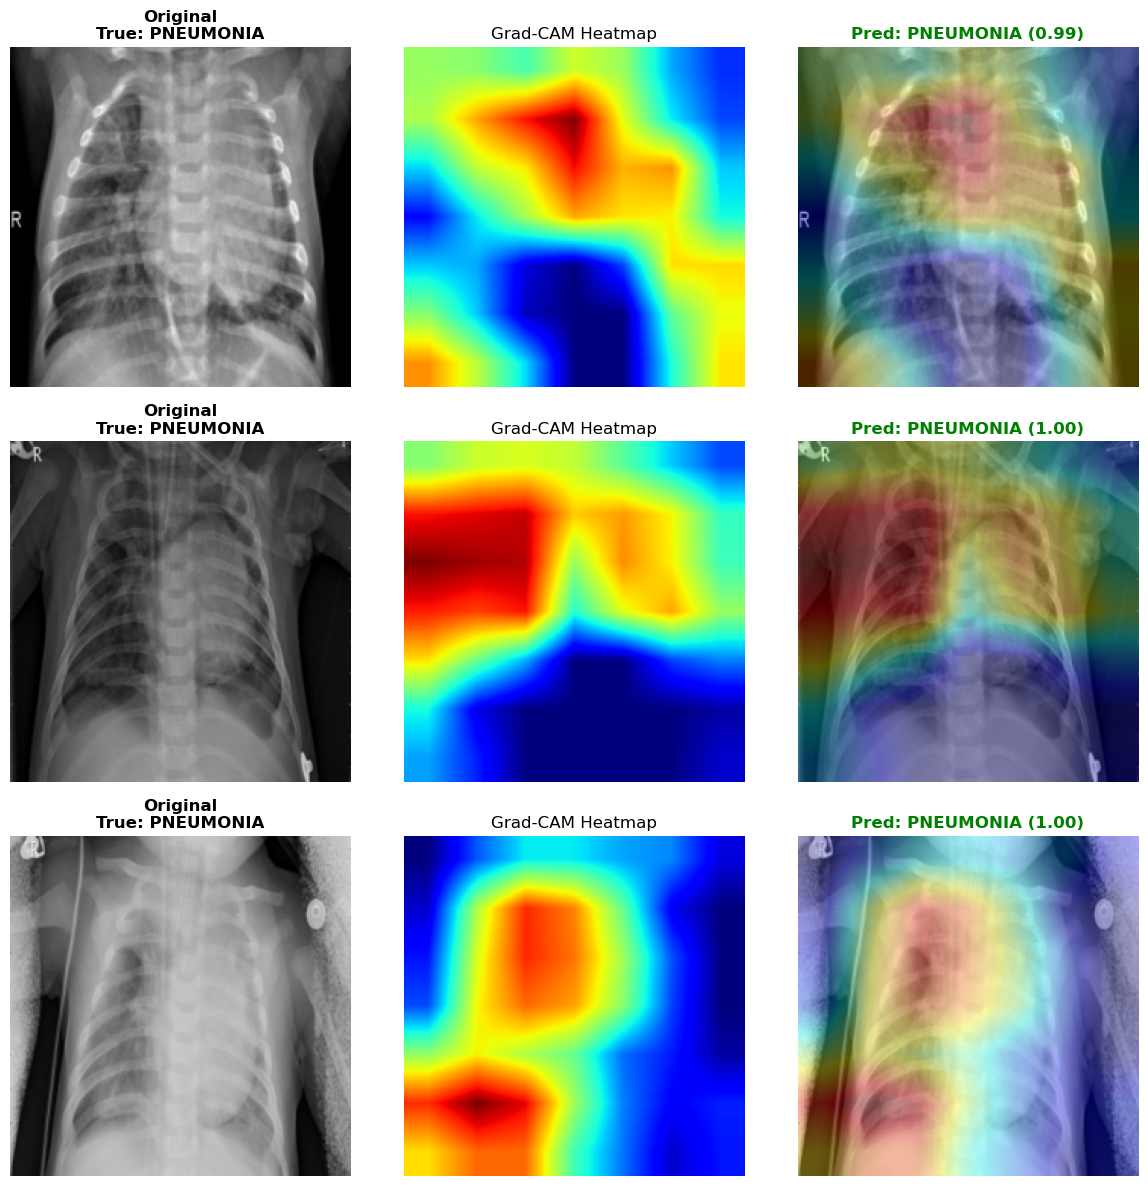

In [ ]:
# Visualizations.

def visualize_gradcam_samples(model, test_loader, gradcam, device, num_samples=6, target_label=None):
    """
    Generates Grad-CAM visualizations for a specified number of samples from the test loader.
    """

    model.eval()
    
    # This ensures that specific samples matching the requested class are identified.
    collected_images = []
    collected_labels = []
    
    # Iterate through the data loader to collect matching samples.
    for images, labels in test_loader:
        for i in range(len(labels)):
            # Collect the sample if no filter is applied (None) or if the label matches the target.
            if target_label is None or labels[i].item() == target_label:
                collected_images.append(images[i])
                collected_labels.append(labels[i])
            
            # Terminate search upon reaching the requested number of samples.
            if len(collected_images) >= num_samples:
                break
        if len(collected_images) >= num_samples:
            break
    
    # Validation: Ensure samples were found before proceeding.
    if not collected_images:
        print("No samples found for the specified class.")
        return

    # Convert the collected list of tensors back into a batch tensor.
    images = torch.stack(collected_images).to(device)
    labels = torch.tensor(collected_labels)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    if num_samples == 1: axes = np.expand_dims(axes, 0) 
    
   
    class_title = "RANDOM MIX"
    if target_label == 0: class_title = "NORMAL CASES"
    if target_label == 1: class_title = "PNEUMONIA CASES"
    print(f"\n--- Visualizing: {class_title} ---")

    for idx in range(num_samples):
        img_tensor = images[idx:idx+1]
        true_label = labels[idx].item()
        
        # Generate Visualization.
        heatmap, superimposed, pred_label, confidence = generate_visualization(
            gradcam, img_tensor, device
        )
        
        img_np = denormalize_image(img_tensor, device)
        
        # Plotting.
        # Column 1: Original.
        axes[idx, 0].imshow(img_np)
        # Enhanced plot titles with bold font for improved readability.
        axes[idx, 0].set_title(f"Original\nTrue: {class_names[true_label]}", fontsize=12, weight='bold')
        axes[idx, 0].axis("off")
        
        # Column 2: Heatmap.
        axes[idx, 1].imshow(heatmap, cmap="jet")
        axes[idx, 1].set_title("Grad-CAM Heatmap", fontsize=12)
        axes[idx, 1].axis("off")
        
        # Column 3: Superimposed.
        title_color = "green" if pred_label == true_label else "red"
        axes[idx, 2].imshow(superimposed)
        axes[idx, 2].set_title(
            f"Pred: {class_names[pred_label]} ({confidence:.2f})", 
            fontsize=12, color=title_color, weight="bold"
        )
        axes[idx, 2].axis("off")
    
    plt.tight_layout()
    plt.show()


# 1. Visualize 3 NORMAL cases.
visualize_gradcam_samples(model, test_loader, gradcam, device, num_samples=3, target_label=0)

# 2. Visualize 3 PNEUMONIA cases.
visualize_gradcam_samples(model, test_loader, gradcam, device, num_samples=3, target_label=1)

### 8. Single Instance Analysis
A utility function designed to analyze specific image files by path. This allows for the detailed examination of specific cases of interest, such as difficult diagnoses or potential false positives found during the evaluation phase.

Checking path: ../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg
Analyzing specific image: ../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg


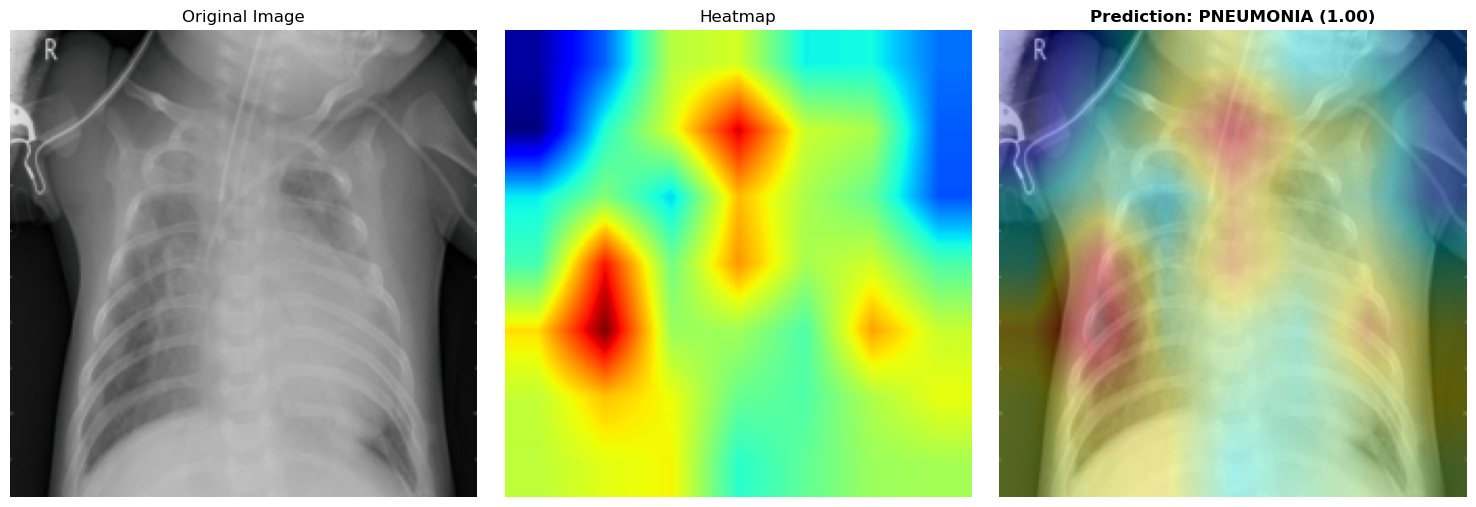

In [ ]:
# Define the specific file path intended for testing.
target_image_path = "../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"

print(f"Checking path: {target_image_path}")

if os.path.exists(target_image_path):
    print(f"Analyzing specific image: {target_image_path}")
    analyze_single_image(target_image_path, model, gradcam, device)
else:
   
    print(f"File not found directly. Searching in folder...")
    folder_path = "../data/chest_xray/test/PNEUMONIA/"
    
    if os.path.exists(folder_path):
        images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        if images:
            sample_path = os.path.join(folder_path, images[0])
            print(f"Found alternative image: {sample_path}")
            analyze_single_image(sample_path, model, gradcam, device)
        else:
            print("No images found in the PNEUMONIA folder.")
    else:
        print(f"Directory not found: {folder_path}")